# Learning to Learn with Quantum Neural Network

## Variational Quantum Algorithms (VQAs)

These are algorithms having a quantum part with parameters (for instance angles of rotations gates) which are optimized by a classical computer. Variational algorithm are used in <u>Quantum Machine Learning</u> for instance: the goal is to find the best parameters of what is called the **ansatz** circuit to get the best results.

A major <u>challenge</u> for **VQAs** relates to the <u>optimization of tunable parameters</u>, which was shown to be a very hard task. <u>Parameter initialization</u> plays a key role in this scenario, since initializing the parameters in the proximity of an optimal solution leads to faster convergence and better results. Thus, a <u>good initialization strategy</u> is crucial to promote the convergence of local optimizers to local extrema and to select reasonably good local minima.

One such strategy could come from the classical machine learning literature: **Recurrent Neural Networks.**
<center>
    <figure>
        <img src="images/vqa.png" width=50%>
    </figure>
</center>

<!--
Resources:
- [VQA](https://quantumcomputing.stackexchange.com/questions/31640/what-exactly-are-variational-quantum-algorithms)
-->

## Classical Recurrent Neural Networks

<center>
    <figure>
        <img src="images/rnn.png" width=50%>
    </figure>
</center>

In [1]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np

import tensorflow as tf
import networkx as nx
import matplotlib.pyplot as plt
import random

# Fix the seed for reproducibility, which affects all random functions in this demo
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """Generate a list containing random graphs generated by Networkx."""

    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints

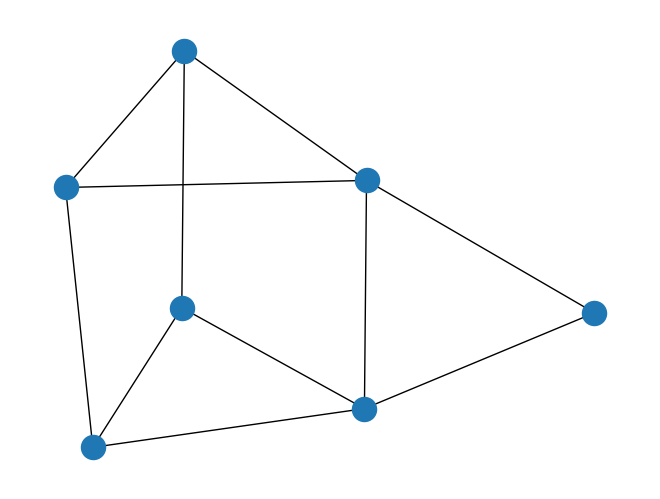

In [3]:
# Define parameters of the graphs
n_graphs = 20
n_nodes = 7
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

## Variational Quantum Circuit: QAOA

In [4]:
def qaoa_from_graph(graph, n_layers=1):
    """Uses QAOA to create a cost Hamiltonian for the MaxCut problem."""

    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))

    # Define the structure of the cost and mixer subcircuits for the MaxCut problem
    cost_h, mixer_h = qaoa.maxcut(graph)

    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)

    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(cost_h)

    # Evaluates the cost Hamiltonian
    def hamiltonian(params, **kwargs):
        """Evaluate the cost Hamiltonian, given the angles and the graph."""

        # We set the default.qubit.tf device for seamless integration with TensorFlow
        dev = qml.device("default.qubit.tf", wires=len(graph.nodes))

        # This qnode evaluates the expectation value of the cost hamiltonian operator
        cost = qml.QNode(circuit, dev, diff_method="backprop", interface="tf")

        return cost(params)

    return hamiltonian

## Recurrent Neural Network: LSTM

In [5]:
# Create an instance of a QAOA circuit given a graph.
cost = qaoa_from_graph(graph=graphs[0], n_layers=1)

# Since we use only one layer in QAOA, params have the shape 1 x 2,
# in the form [[alpha, gamma]].
x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)

# Evaluate th QAOA instance just created with some angles.
print(cost(x))

tf.Tensor(-3.1932679572555784, shape=(), dtype=float64)


In [6]:
# Set the number of layers in the QAOA ansatz.
# The higher the better in terms of performance, but it also gets more
# computationally expensive. For simplicity, we stick to the single layer case.
n_layers = 1

# Define a single LSTM cell.
# The cell has two units per layer since each layer in the QAOA ansatz
# makes use of two parameters.
cell = tf.keras.layers.LSTMCell(2 * n_layers)

In [7]:
# We create the QAOA MaxCut cost functions of some graphs
graph_cost_list = [qaoa_from_graph(g) for g in graphs]

In [8]:
def rnn_iteration(inputs, graph_cost, n_layers=1):
    """Perform a single time step in the computational graph of the custom RNN."""

    # Unpack the input list containing the previous cost, parameters,
    # and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]

    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])

    # Call the LSTM cell, which outputs new values for the parameters along
    # with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])

    # Reshape the parameters to correctly match those expected by PennyLane
    _params = tf.reshape(new_params, shape=(2, n_layers))

    # Evaluate the cost using new angles
    _cost = graph_cost(_params)

    # Reshape to be consistent with other tensors
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))

    return [new_cost, new_params, new_h, new_c]


def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):
    """Creates the recurrent loop for the Recurrent Neural Network."""

    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = tf.zeros(shape=(1, 1))
    initial_params = tf.zeros(shape=(1, 2 * n_layers))
    initial_h = tf.zeros(shape=(1, 2 * n_layers))
    initial_c = tf.zeros(shape=(1, 2 * n_layers))

    # We perform five consecutive calls to 'rnn_iteration', thus creating the
    # recurrent loop. More iterations lead to better results, at the cost of
    # more computationally intensive simulations.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)

    # This cost function takes into account the cost from all iterations,
    # but using different weights.
    loss = tf.keras.layers.average(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]]
    )

    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

In [9]:
def train_step(graph_cost):
    """Single optimization step in the training procedure."""

    with tf.GradientTape() as tape:
        # Evaluates the cost function
        loss = recurrent_loop(graph_cost)

    # Evaluates gradients, cell is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)

    # Apply gradients and update the weights of the LSTM cell
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i+1}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >> Mean Loss during epoch: {np.mean(total_loss)}")

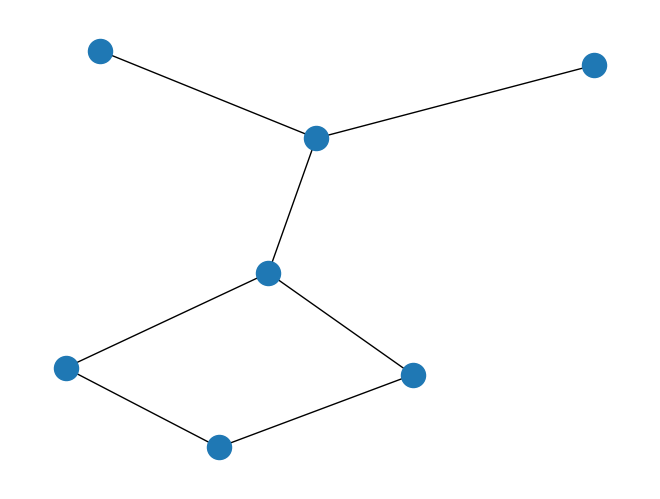

In [15]:
new_graph = nx.gnp_random_graph(7, p=3 / 7)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

In [16]:
# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps=True)

# Extract all angle suggestions
start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = res[0]
guess_1 = res[1]
guess_2 = res[2]
guess_3 = res[3]
guess_4 = res[4]
final_loss = res[5]

# Wrap them into a list
guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

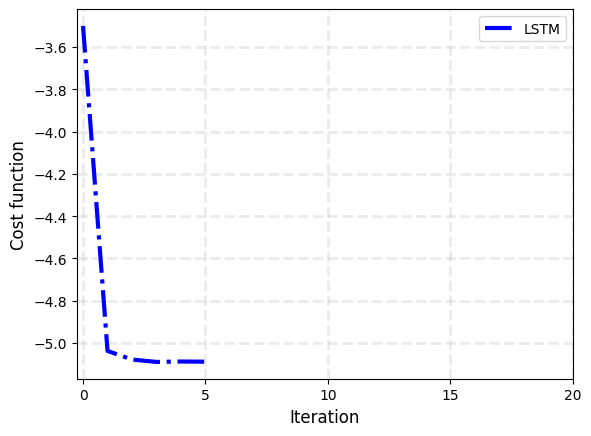

In [17]:
fig, ax = plt.subplots()

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

In [18]:
# Parameters are randomly initialized
x = tf.Variable(np.random.rand(2, 1))

# We set the optimizer to be a Stochastic Gradient Descent
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

# Training process
steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)

    steps.append(x)
    sdg_losses.append(loss)

    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_+1} - Loss = {loss}")

print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 1 - Loss = -3.5571928993190634
Step 2 - Loss = -3.5873417992512215
Step 3 - Loss = -3.62146784318947
Step 4 - Loss = -3.6610328380589645
Step 5 - Loss = -3.7073940054193617
Step 6 - Loss = -3.7617013712583542
Step 7 - Loss = -3.8247460223909906
Step 8 - Loss = -3.896774028777722
Step 9 - Loss = -3.977304426752111
Step 10 - Loss = -4.065012943858276
Step 11 - Loss = -4.1577508866161565
Step 12 - Loss = -4.252743956890036
Step 13 - Loss = -4.34695539339044
Step 14 - Loss = -4.437525370323364
Step 15 - Loss = -4.522157301018783
Final cost function: -4.599342403259401
Optimized angles: [[0.36300476]
 [1.11038898]]


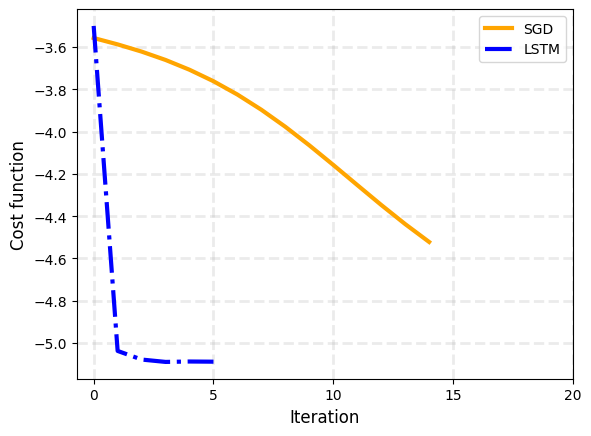

In [19]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color="orange", lw=3, label="SGD")

plt.plot(lstm_losses, color="blue", lw=3, ls="-.", label="LSTM")

plt.grid(ls="--", lw=2, alpha=0.25)
plt.legend()
plt.ylabel("Cost function", fontsize=12)
plt.xlabel("Iteration", fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

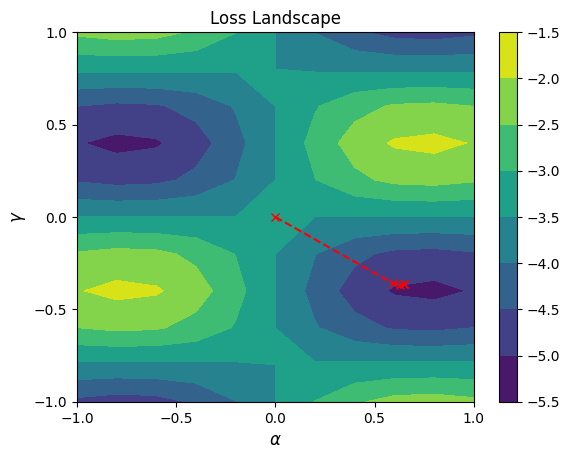

In [20]:
# Evaluate the cost function on a grid in parameter space
dx = dy = np.linspace(-1.0, 1.0, 11)
dz = np.array([new_cost([[xx], [yy]]).numpy() for yy in dy for xx in dx])
Z = dz.reshape((11, 11))

# Plot cost landscape
plt.contourf(dx, dy, Z)
plt.colorbar()

# Extract optimizer steps
params_x = [0.0] + [res[i].numpy()[0, 0] for i in range(len(res[:-1]))]
params_y = [0.0] + [res[i].numpy()[0, 1] for i in range(len(res[:-1]))]

# Plot steps
plt.plot(params_x, params_y, linestyle="--", color="red", marker="x")

plt.yticks(np.linspace(-1, 1, 5))
plt.xticks(np.linspace(-1, 1, 5))
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel(r"$\gamma$", fontsize=12)
plt.title("Loss Landscape", fontsize=12)
plt.show()